# Python による MRI データの読み込みと可視化

このノートブックでは、Python を用いて MRI データを読み込み、表示する方法を説明します。
MRI データの読み込みには、**nibabel** という Python パッケージを用いて MRI データを扱います。

Neuroimaging in Python — NiBabel 5.0.0 documentation https://nipy.org/nibabel/nibabel_images.html

In [1]:
!pip install nibabel

     |████████████████████████████████| 3.3 MB 10.3 MB/s eta 0:00:01


In [2]:
import os

import nibabel
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [3]:
# データの取得
!mkdir data

In [4]:
!wget -O data/sub-01_ses-anatomy_T1w.nii.gz https://openneuro.org/crn/datasets/ds001506/snapshots/1.3.1/files/sub-01:ses-anatomy:anat:sub-01_ses-anatomy_T1w.nii.gz

--2023-03-14 16:01:53--  https://openneuro.org/crn/datasets/ds001506/snapshots/1.3.1/files/sub-01:ses-anatomy:anat:sub-01_ses-anatomy_T1w.nii.gz
Resolving openneuro.org (openneuro.org)... 34.107.158.10
Connecting to openneuro.org (openneuro.org)|34.107.158.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/gzip]
Saving to: 'data/sub-01_ses-anatomy_T1w.nii.gz'

data/sub-01_ses-ana     [     <=>            ]  10.00M  12.3MB/s    in 0.8s    

2023-03-14 16:01:54 (12.3 MB/s) - 'data/sub-01_ses-anatomy_T1w.nii.gz' saved [10487360]



In [5]:
!wget -O data/sub-01_ses-perceptionNaturalImageTest01_task-perception_run-01_bold.nii.gz https://openneuro.org/crn/datasets/ds001506/snapshots/1.3.1/files/sub-01:ses-perceptionNaturalImageTest01:func:sub-01_ses-perceptionNaturalImageTest01_task-perception_run-01_bold.nii.gz

--2023-03-14 16:01:56--  https://openneuro.org/crn/datasets/ds001506/snapshots/1.3.1/files/sub-01:ses-perceptionNaturalImageTest01:func:sub-01_ses-perceptionNaturalImageTest01_task-perception_run-01_bold.nii.gz
Resolving openneuro.org (openneuro.org)... 34.107.158.10
Connecting to openneuro.org (openneuro.org)|34.107.158.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/gzip]
Saving to: 'data/sub-01_ses-perceptionNaturalImageTest01_task-perception_run-01_bold.nii.gz'

data/sub-01_ses-per     [       <=>          ] 184.05M  35.1MB/s    in 5.4s    

2023-03-14 16:02:01 (34.4 MB/s) - 'data/sub-01_ses-perceptionNaturalImageTest01_task-perception_run-01_bold.nii.gz' saved [192988062]



## 構造 MRI 画像

まず，構造 MRI 画像 (structural/anatomical MRI image) と呼ばれる，脳の形状を調べるための MRI 画像を取り扱います．

はじめに，NIfTI 形式の脳画像ファイルを読み込みます．
読み込まれた画像は `nibabel.nifti1.Nifti1Image` という NIfTI 画像クラスのオブジェクトに格納されます．
この画像オブジェクトから，以下のようにして画像データを取り出すことができます．

In [6]:
# 構造 MRI 画像 (3 次元 NIfTI 画像) の読み込み
img_t1 = nibabel.load(os.path.join('data', 'sub-01_ses-anatomy_T1w.nii.gz'))

# 画像オブジェクトを Numpy 配列として取り出す
data_t1 = img_t1.get_fdata()
data_t1.shape

(256, 256, 208)

読み込んだ MRI 画像 (`sub-01_ses-anatomy_T1w.nii.gz`) の大きさが $256 \times 256 \times 208$ であることがわかります．

また，画像の各次元がそれぞれどの方向に対応しているかは，以下の方法で調べることができます．

In [7]:
nibabel.aff2axcodes(img_t1.affine)

('P', 'I', 'L')

N 番目の文字はそれぞれ，画像の N 次元の，インデックスが増加する方向を表わしています．

- **A**/**P**: Anterior (前)/Posterior (後)
- **S**/**I**: Superior (上)/Inferior (下)
- **L**/**R**: Left (左)/Right (右)

参考: [Anatomical terms of location - Wikipedia](https://en.wikipedia.org/wiki/Anatomical_terms_of_location)

すなわちこの画像は，1 次元目が「前 → 後」，2 次元目が「上 → 下」，3 次元目が「右 → 左」になっています．

<hr>

*Note: MRI 画像のアフィン行列*

`imt_t1.affine` には，MRI 画像のアフィン行列 (affine matrix) が格納されています．
このアフィン行列は，MRI 画像のボクセル (各画素) を，何らかの座標系へと投射する変換をあらわしています．
投射先の座標系として，MNI 標準座標系などがよく用いられます．
何らかの共通した座標系に合わせることによって，異なる脳画像間で位置を比較することができます．

<hr>

また，各ボクセル (MRI 画像の 1 画素) の大きさは，画像オブジェクトのヘッダ情報から以下のようにして取得できます (単位: mm)．
`header` には他にも様々な情報が格納されていますが，本演習ではその詳細は割愛します．

In [8]:
img_t1.header.get_zooms()

(1.0, 1.0, 1.0)

それでは，脳の冠状面 (coronal plane; 脳を前後に分ける面) の画像を表示してみましょう．
そのために，Anterior/posterior 軸の真ん中のデータを取り出し，2 次元の画像として表示します．

<hr>

*Note*: 冠状面，矢状面，横断面 (軸位面)

<figure>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/Human_anatomy_planes-JA.svg/1000px-Human_anatomy_planes-JA.svg.png" width="30%">
<figcaption>出典: <a href="https://commons.wikimedia.org/wiki/File:Human_anatomy_planes-JA.svg" target="_blank">Wikipedia</a></figcaption>
</figure>
<hr>

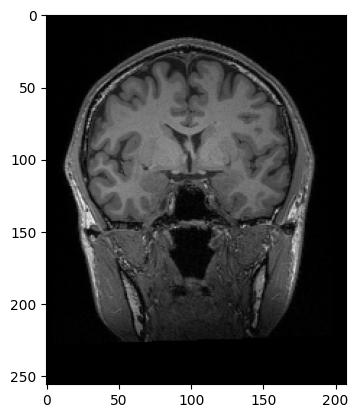

In [9]:
plt.imshow(data_t1[data_t1.shape[0] // 2, :, :], cmap='gray')
plt.show()

脳の*横断面* (transverse plane, axial plane; 脳を上下に分ける面) と*矢状面* (sagittal plane; 体を左右に分ける面) の画像を表示してみましょう．

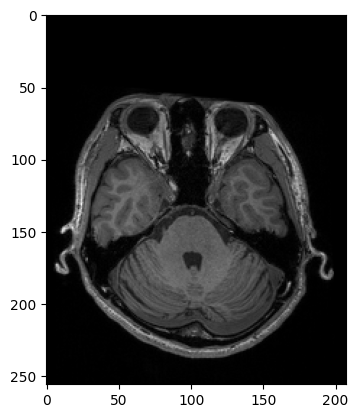

In [10]:
# 横断面
plt.imshow(data_t1[:, data_t1.shape[1] // 2, :], cmap='gray')
plt.show()

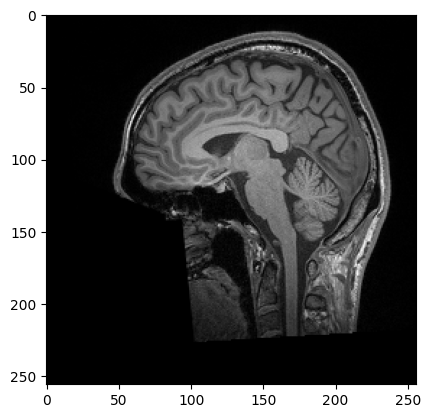

In [11]:
# 矢状面
plt.imshow(data_t1[:, :, data_t1.shape[2] // 2].T, cmap='gray')
plt.show()

## 機能 MRI 画像

次に，機能 MRI (functional MRI; fMRI) 画像と呼ばれる，脳活動の時系列を計測した MRI 画像を読み込み，表示します．
MRI 画像としては構造 MRI 画像と同様に扱うことができますが，一般に fMRI 画像は，脳全体の撮像を一定時間ごとに繰り返すため，ひとつの画像の中に 3 次元の脳データが複数個，時系列に沿って格納されています．
したがって，データは 4 次元 (3 次元空間 + 時間) になります．

In [12]:
# 機能 MRI 画像 (fMRI; 4 次元 NIfTI 画像) の読み込み
img_fmri = nibabel.load(os.path.join('data', 'sub-01_ses-perceptionNaturalImageTest01_task-perception_run-01_bold.nii.gz'))

# 画像オブジェクトを Numpy 配列として取り出す
data_fmri = np.asanyarray(img_fmri.dataobj)
data_fmri.shape

(96, 96, 76, 239)

今回読み込んだデータは 4 次元であることがわかります．
最初の 3 次元は空間，最後の 4 次元目が時間です．
したがって，このファイルには 239 回の脳活動計測のデータが含まれています．

先程と同様に，(空間の) 3 つの次元の方向を確認します．

In [13]:
nibabel.aff2axcodes(img_fmri.affine)

('L', 'P', 'S')

すなわちこの画像は，1 次元目が「右 → 左」，2 次元目が「前 → 後」，3 次元目が「下 → 上」になっています．

このように，MRI 画像の次元は撮像時の設定によって異なる空間軸に対応しています．
前節で紹介したようなビューワを用いる場合，ビューワが空間軸の情報を読み取って画像を適切に表示してくれます．
Python 等を用いて自分で MRI 画像を処理・表示する場合，画像の次元と空間の対応に気を付ける必要があります (特に左右)．

また，先程と同様にボクセルの大きさを確認します．

In [14]:
img_fmri.header.get_zooms()

(2.0, 2.0, 2.0, 2.0)

この画像のボクセルサイズは $2 \times 2 \times 2$ mm です．最後の要素は，脳画像計測の時間間隔 (秒) を示しています (*)．

\* 厳密には「N 秒ごとに 1 回，脳全体を撮像する」のではなく「約 N 秒かけて脳全体を 1 回撮像する」ことになります．

機能 MRI のデータから、1 回の計測分のデータを取り出し，矢状面を表示してみましょう．

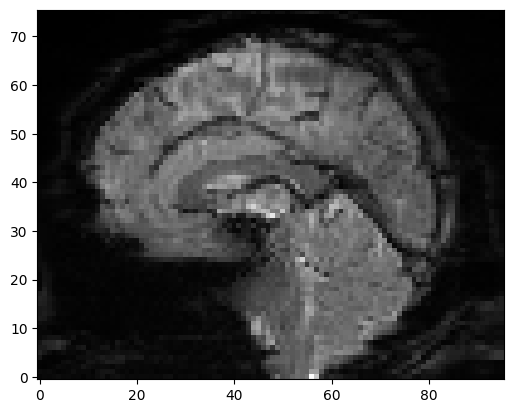

In [15]:
plt.imshow(data_fmri[data_fmri.shape[0] // 2, :, :, 0].T, cmap='gray', origin='lower')
plt.show()

次に，同じ矢状面の脳画像の時系列をアニメーションで表示してみましょう．

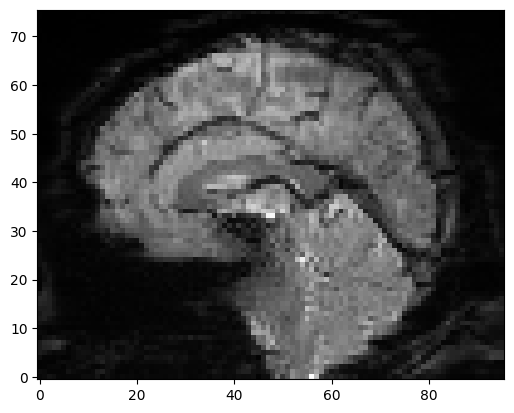

In [16]:
fig = plt.figure()

frames = []
for i in range(20):
    frames.append(data_fmri[data_fmri.shape[0] // 2, :, :, i].T)

def update(frame):
    return plt.imshow(frame, cmap='gray', origin='lower'),

animation = FuncAnimation(
    fig, update,
    frames=frames,
    blit=True,
    interval=200 # 単位: ミリ秒
)
# 実際の計測は 2 秒ごとに行われています．ここでは 0.2 秒ごとにフレームを更新しています．
# つまり実際の 10 倍速でアニメーションを表示しています．

HTML(animation.to_jshtml())